In [61]:
import pandas as pd
import numpy as np
path = 'dataset/labelled_tweets.csv'
positive_amazon = 'dataset/amazon_positive.csv'
    
tweet = pd.read_csv(path, usecols=['text', 'polarity'])

# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences
positive_amazon = pd.read_csv(positive_amazon, usecols=['text', 'polarity'])

# Remove rows will nan values
tweet = tweet.dropna()
positive_amazon = positive_amazon.dropna(axis=1, how="any")

# preprocessing bit
# replace user handles (@Jumia) to be empty
pattern = "(@[A-Za-z0-9]+)|(http|https|ftp)://[a-zA-Z0-9./]+|#(\w+)"
tweet['text'] = tweet.text.str.replace(pattern, '')

# Due to the limited number of positive tweets, 
# I appended some positive tweets from Amazon Dataset
tweet = tweet.append(positive_amazon).drop_duplicates().reset_index(drop=True)

# Remove duplicated index
# tweet = tweet.groupby(tweet.index).first()
# Random shuffling
tweet = tweet.reindex(np.random.permutation(tweet.index))
tweet.head()

,polarity,text
1887,positive,Really pleased with this product so far.
738,neutral,305827286
1711,neutral,kindly confirm if this order has been cancell...
189,neutral,The attached screenshot is the exact device pi...
1644,neutral,kindly comfirm the statud of the order


In [62]:
tweet[tweet.index.duplicated()]

,polarity,text


In [63]:
# examine class distribution
print(tweet.polarity.value_counts())

neutral     933
negative    746
positive    583
Name: polarity, dtype: int64


In [64]:
# Summary of data
print(tweet.describe())

       polarity    text
count      2262    2262
unique        3    2256
top     neutral  Thanks
freq        933       2


### Dataset Visualization

In [65]:
# convert label to a numerical count by creating a new column
tweet['polarity'] = tweet.polarity.map({'negative':0,'positive':1,'neutral':2})

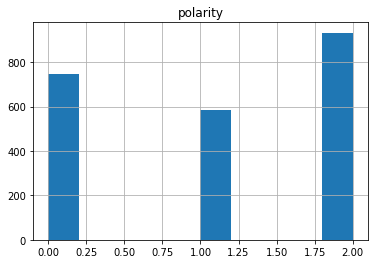

In [66]:
import matplotlib.pyplot as plt
tweet.hist()
plt.show()

In [67]:
# Define X matrix as features and y as vectors
X = tweet.text
y = tweet.polarity
print(X.shape)
print(y.shape)

(2262,)
(2262,)


In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1696,)
(566,)
(1696,)
(566,)


In [69]:
# Import libraries
import re
import numpy as np

from sklearn import model_selection

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [86]:
vect = TfidfVectorizer()

x_train = vect.fit_transform(X_train)

### Test Harness
* Use 10-fold cross validation to determine the best classifier.
* Metric accuracy is used to evaluate the models. (A ratio of number of correctly predicted instances divided by total number of the instances in dataset-tweet)

In [87]:
seed = 4
# Evaluation metric
scoring = 'accuracy'

# Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC()))
models.append(('SGDC', SGDClassifier()))
# Evaluate model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    message = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(message)

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


LR: 0.781270 (0.027290)
KNN: 0.438688 (0.036570)
CART: 0.636220 (0.031702)
SVM: 0.415674 (0.038023)
SGDC: 0.778319 (0.023149)


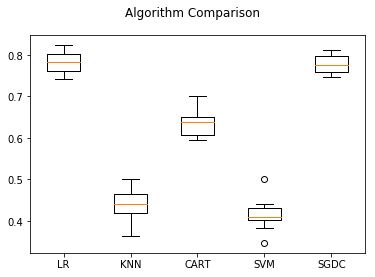

In [88]:
# TODO: Visual comparison of algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### SGDClassifier

In [89]:
clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer(use_idf=True)), ('clf', SGDClassifier(loss='hinge',penalty='l2', n_iter=5,alpha=0.001,random_state=42))])
clf_svm = clf_svm.fit(X_train,y_train)
y_pred_svm = clf_svm.predict(X_test)
print(metrics.classification_report(y_test, y_pred_svm))
print("SGDClassifier Accuracy: ", metrics.accuracy_score(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.77      0.74      0.76       200
          1       0.87      0.89      0.88       138
          2       0.77      0.79      0.78       228

avg / total       0.79      0.80      0.79       566

SGDClassifier Accuracy:  0.795053003534


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
clf_reg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
clf_reg = clf_reg.fit(X_train,y_train)
y_pred_reg = clf_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_reg))
print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, y_pred_reg))

             precision    recall  f1-score   support

          0       0.78      0.71      0.75       200
          1       0.89      0.85      0.87       138
          2       0.73      0.80      0.76       228

avg / total       0.79      0.78      0.78       566

Logistic Regression Accuracy:  0.782685512367


### Grid Search
Obtain the best parameters to pass to the model, for best classification accuracy

In [36]:
from sklearn.model_selection import GridSearchCV 
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),}

gs_clf = GridSearchCV(clf_svm, parameters, n_jobs=-1, cv=10)
gs_clf = gs_clf.fit(X_train, y_train)

In [37]:
gs_clf.best_score_

0.78381502890173416

In [38]:
gs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

### Confusion Matrix


This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Confusion matrix, without normalization
[[147   5  33]
 [  9 115  33]
 [ 39   5 191]]
Normalized confusion matrix
[[ 0.79  0.03  0.18]
 [ 0.06  0.73  0.21]
 [ 0.17  0.02  0.81]]


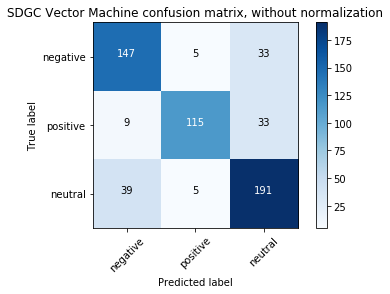

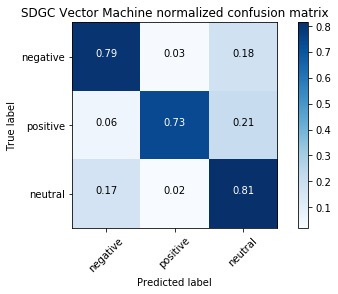

In [39]:
"""
This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['negative','positive','neutral']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for all predicted y

predicted_y = [y_pred_svm]

titles = ['SDGC Vector Machine']

for index, y_prediction in enumerate(predicted_y):
    cnf_matrix = confusion_matrix(y_test, y_prediction)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title=titles[index] + ' confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=titles[index] + ' normalized confusion matrix')

    plt.show()

In [40]:
clf_svm.predict(['great'])

array([1], dtype=int64)

# Topic Modelling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_index))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

In [ ]:
nmf.components_.shape

### NMF and LDA Summarized Topics

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 2

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

no_top_words = 4
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, X, no_top_words, no_top_documents)
display_topics(lda_H, lda_W, tf_feature_names, X, no_top_words, no_top_documents)

In [ ]:
titles[0]

In [ ]:
for i, title in enumerate(titles):
    print(i)